In [84]:
from dotenv import load_dotenv
load_dotenv()

True

In [85]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [86]:
# State define
from typing import TypedDict, Annotated
from langgraph.graph import add_messages

class ChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [87]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [88]:
@tool
def get_price(symbol: str) -> float:
    # required docstring -> needed for langchain to identify the tool
    """Return the stock price for the given symbol."""
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_price]
llm_with_tools = llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [89]:
tools

[StructuredTool(name='get_price', description='Return the stock price for the given symbol.', args_schema=<class 'langchain_core.utils.pydantic.get_price'>, func=<function get_price at 0x00000248289F0C20>)]

In [90]:
def chatbot(state: ChatState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [91]:
# graph with tool
from langgraph.graph import StateGraph, START, END
builder = StateGraph(ChatState)
builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
# from tool call loop back to the llm to generate proper ans
builder.add_edge("tools", "chatbot")

graph = builder.compile()

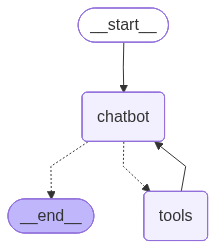

In [92]:
# Visualising the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
res = graph.invoke({'messages': ['I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost? Add 15 AAPL to it.']})
res

{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost? Add 15 AAPL to it.', additional_kwargs={}, response_metadata={}, id='99554ee1-670f-468d-9707-bcd6d4228769'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_price', 'arguments': '{"symbol": "AAPL"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--f9fa0af4-f198-4f2e-8c58-2c7a50800115-0', tool_calls=[{'name': 'get_price', 'args': {'symbol': 'AMZN'}, 'id': 'd4137183-4996-4a81-99b3-b74fd014efe1', 'type': 'tool_call'}, {'name': 'get_price', 'args': {'symbol': 'MSFT'}, 'id': '290728cd-110b-45fb-8662-bb83be6d6407', 'type': 'tool_call'}, {'name': 'get_price', 'args': {'symbol': 'AAPL'}, 'id': '8885478b-ea95-4154-af1a-4b054a1905ad', 'type': 'tool_call'}], usage_metadata={'input_tokens': 62, 'output_tokens': 18, 'total_tokens': 80}),
  ToolMessage(cont

In [94]:
res['messages'][-1].content 

'OK. The price for AMZN is 200.3, for MSFT is 100.4, and for AAPL is 150.\nThe total cost will be 20 * 200.3 + 15 * 100.4 + 15 * 150 = 9261.0'

## ***Memory Utilisation***

In [95]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()

In [96]:
graph2 = builder.compile(checkpointer=checkpointer)

In [97]:
config1 = {"configurable": {"thread_id": "1"}} # suppose it's the chats of user 1
res = graph2.invoke({'messages': ['I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?']}, config=config1)
res['messages'][-1].content 

'AMZN is trading at $150 and MSFT is trading at $150.\n\nTo buy 20 AMZN stocks, it would cost 20 * $150 = $3000.\nTo buy 15 MSFT stocks, it would cost 15 * $150 = $2250.\n\nTherefore, the total cost would be $3000 + $2250 = $5250.\n'

In [98]:
config2 = {"configurable": {"thread_id": "2"}} # suppose it's the chats of user 2
res = graph2.invoke({'messages': ['I want to buy 20 AMZN stocks using current price. What will be the total cost? Then add 15 AAPL.']}, config=config2)
res['messages'][-1].content 

'AMZN costs $150.00, so 20 shares would be $3000.\nAAPL costs $150.00, so 15 shares would be $2250.\nThe total cost would be $5250.00.\n'

In [99]:
res = graph2.invoke({'messages': ['What will be the total ammount?']}, config=config2)
res['messages'][-1].content 

'The total amount for 20 AMZN stocks and 15 AAPL stocks would be $5250.00.\n'

In [100]:
res = graph2.invoke({'messages': ['How?']}, config=config2)
res['messages'][-1].content 

"Okay, let's break it down:\n\n*   **AMZN:** You want 20 shares, and the price per share is $150. So, 20 * $150 = $3000\n\n*   **AAPL:** You want 15 shares, and the price per share is $150. So, 15 * $150 = $2250\n\n*   **Total:** To find the total cost, you add the cost of the AMZN shares and the AAPL shares: $3000 + $2250 = $5250\n\nTherefore, the total amount is $5250.\n"

In [101]:
res = graph2.invoke({'messages': ['AAPL is not 104?']}, config=config2)
res['messages'][-1].content 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details..


ResourceExhausted: 429 Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.